# Chapter 4: 모델 훈련

이 장에서는 대표적인 모델들이 돌아가는 작동 원리를 살펴봄  
모델들이 어떻게 작동하는지를 잘 이해하고 있으면 적절한 모델, 올바른 훈련 알고리즘, 작업에 맞는 좋은 하이퍼파라미터를 빠르게 찾을 수 있다고 함

# 기본 설정

In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 4.1 선형 회귀

모델을 훈련시킨다는 것은 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정하는 것  
선형 회귀 모델을 훈련시키려면 평균 제곱 오차(MSE)를 최소화하는 θ를 찾아야 함

## 4.1.1 정규방정식

**식 4-4: 정규 방정식**

$\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$

정규방정식 공식을 테스트하기 위해 선형처럼 보이는 데이터를 생성

In [3]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

그림 저장: generated_data_plot


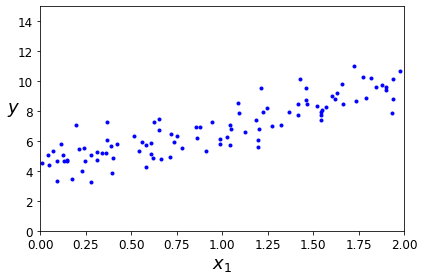

In [4]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

이제 정규방정식을 사용해 $\hat{\boldsymbol{\theta}}$를 계산  
넘파이 선형대수 모듈(`np.linalg`)에 있는 `inv()` 함수를 사용해 역행렬을 계산하고 `dot()` 메소드를 사용해 행렬 곱셈을 진행

In [5]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

정규방정식으로 계산한 값을 확인

In [6]:
theta_best

array([[4.21509616],
       [2.77011339]])

${\boldsymbol{\theta}}$0=4.215와 ${\boldsymbol{\theta}}$1=2.770 대신 ${\boldsymbol{\theta}}$0=4와 ${\boldsymbol{\theta}}$1=3을 기대했었지만 잡음 때문에 원래 함수의 파라미터를 정확하게 재현하지 못했음  

$\hat{\boldsymbol{\theta}}$을 사용해 예측을 진행해보겠음  
$\hat{y} = \mathbf{X} \boldsymbol{\hat{\theta}}$

In [7]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1을 추가
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

모델의 예측을 그래프에 나타내보면 아래와 같음

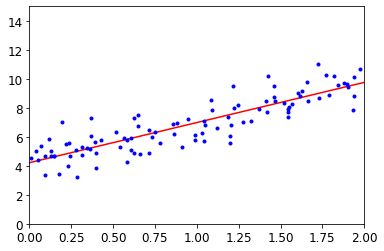

In [8]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

책과 동일하게 범례와 축 레이블을 넣으려면 아래처럼 짜면 됨

그림 저장: linear_model_predictions_plot


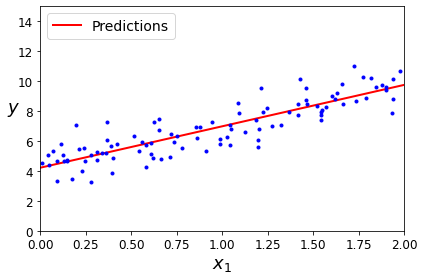

In [9]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

사이킷런에서 선형 회귀를 수행하려면 아래처럼 하면 됨  
사이킷런은 특성의 가중치(coef_)와 편향(intercept_)을 분리하여 저장함

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [11]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

`LinearRegression` 클래스는 `scipy.linalg.lstsq()` 함수("최소 제곱, least squares"의 약자)를 기반으로 하고 있음. 이 함수를 직접 호출할 수 있음(아래)

In [12]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

위 함수는 $\hat{\boldsymbol{\theta}}=\mathbf{X}^+\mathbf{y}$을 계산함.  
$\mathbf{X}^{+}$는 $\mathbf{X}$의 _유사역행렬_ (pseudoinverse)(Moore–Penrose 유사역행렬임). `np.linalg.pinv()`을 사용해서 유사역행렬을 직접 구할 수 있음(아래)

In [13]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

이제 아주 다른 방법으로 선형 회귀 모델을 훈련시켜보겠음

# 4.2 경사 하강법

경사 하강법(Gradient Descent)의 기본 아이디어: 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정해가는 것
* 학습률(learning rate): 경사 하강법에서 중요한 파라미터에 해당하는 '스텝의 크기'

## 4.2.1 배치 경사 하강법

**식 4-6: 비용 함수의 그레이디언트 벡터**

$
\dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
 = \dfrac{2}{m} \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$

**식 4-7: 경사 하강법의 스텝**

$
\boldsymbol{\theta}^{(\text{next step})} = \boldsymbol{\theta} - \eta \dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
$

In [14]:
eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1) # 랜덤 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [15]:
theta

array([[4.21509616],
       [2.77011339]])

정규방정식으로 찾은 것과 theta가 정확히 일치  

학습률 $\eta$을 바꿔 세 가지 다른 학습률을 사용한 예시도 살펴보겠음

In [16]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

그림 저장: gradient_descent_plot


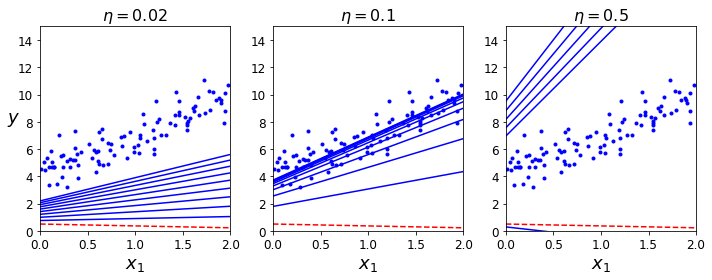

In [17]:
np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

<위 그래프 해석>  
* 빨간 점선이 시작점이고 서로 다른 학습률에 따라 경사 하강법을 진행했을 떄 처음 스텝 10개를 보여주고 있음
* **왼쪽**: 학습률이 **너무 낮음**. 결국엔 최적점에 도달하겠지만 시간이 오래 걸릴 것
* **가운데**: 학습률이 **아주 적당해 보임**. 몇 번의 반복만으로도 이미 최적점에 수렴했음
* **오른쪽**: 학습률이 **너무 높음**. 알고리즘이 이리저리 널뛰면서 최적점에서 오히려 점점 더 멀어지면서 발산하고 있음

## 4.2.2 확률적 경사 하강법

**확률적 경사 하강법(SGD**, Stochastic Gradient Descent): 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그레디언트(미분값)를 계산하는 방법  

<장점>
* 속도가 훨씬 빠름(배치 경사 하강법의 경우 매 스텝에서 전체 훈련 세트를 사용해 그레디언트를 계산해야 하므로 훈련 세트가 커지면 속도가 매우 느려짐)
* 매우 큰 훈련 세트도 훈련 가능(매 반복에서 하나의 샘플만 메모리에 있으면 되므로)  

<단점>
* 배치 경사 하강법보다 훨씬 불안정함(무작위성이라는 확률에 의존하므로)  
=> 학습률을 점진적으로 감소시킴으로써 단점을 보완(시작할 때는 학습률을 크게, 점차 작게 줄여서 알고리즘이 전역 최솟값에 도달하게 함)  


**학습 스케줄(learning schedule)**: 매 반복에서 학습률을 결정하는 함수

In [18]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

그림 저장: sgd_plot


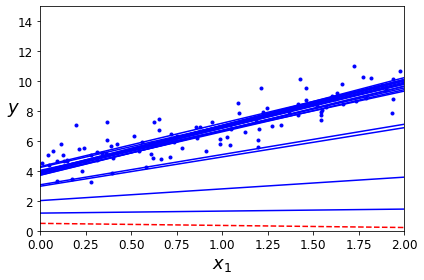

In [19]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                              
save_fig("sgd_plot")                                 
plt.show()                                           

In [20]:
theta

array([[4.21076011],
       [2.74856079]])

일반적으로 한 반복에서 m(훈련 세트에 있는 샘플 수)번 되풀이되고, 이때 각 반복을 **에포크(epoch)**라고 함  

<위 그래프 해석>
* 배치 경사 하강법에서는 1000번 반복(n_iterations = 1000)했던 거에 비해 확률적 경사 하강법에서는 50번만 반복(n_epochs = 50)하고도 매우 좋은 값에 도달했음을 알 수 있음
* 앞선 그래프와 비슷하게 빨간 점선이 시작점이고, 훈련 스텝의 첫 20개를 보여주는데 확실히 배치 경사 하강법보다 스텝이 불규칙하게 진행됨을 눈으로 확인 가능함

사이킷런에서 SGD 방식으로 선형 회귀를 사용하려면 기본값으로 제곱 오차 비용 함수를 최적화하는 **SGDRegressor** 클래스를 사용함  
아래에 사용할 코드에서는 최대 1000번 에포크 동안 실행되거나(**max_iter=1000**) 한 에포크에서 0.001보다 적게 손실이 줄어들 때까지 실행됨(**tol=1e-3**). 학습률은 0.1로(**eta0=0.1**) 기본 학습 스케줄을 사용함. 규제는 아예 사용하지 않았음(**penalty=None**)

In [21]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [22]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

위에서 직접 함수를 정의해서 구한 theta값과 미세한 차이가 있지만 얼추 비슷함을 확인 가능

## 4.2.3 미니배치 경사 하강법

미니배치 경사 하강법(mini-batch gradient descent): 각 스텝에서 **미니배치**라 부르는 임의의 작은 샘플 세트에 대해 그레디언트(미분값)를 계산하는 방법. 즉 전체 훈련 세트(배치 경사 하강법)와 하나의 샘플(확률적 경사 하강법)의 절충이라고 보면 됨  

<장점>
* 행렬 연산에 최적화된 하드웨어(특히 GPU를 사용하는 하드웨어)를 사용해서 얻는 성능 향상
* 미니배치를 어느 정도 크게 하면 파라미터 공간에서 SGD보다 덜 불규칙하게 움직여 SGD보다 최솟값에 더 가까이 도달하게 됨

In [23]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [24]:
theta

array([[4.25214635],
       [2.7896408 ]])

위 코드를 보면 미니배치 사이즈를 20(**minibatch_size = 20**)으로 하여 50회 반복(**n_iterations = 50**)했음을 알 수 있음

지금까지 배운 3가지 경사 하강법 알고리즘이 훈련 과정 동안 파라미터 공간에서 움직인 경로를 그래프로 나타내면 아래와 같음

In [25]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

그림 저장: gradient_descent_paths_plot


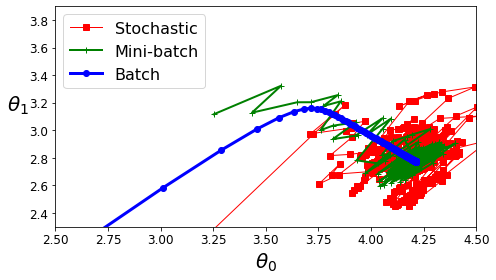

In [26]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

<위 그래프 해석>
* 모두 최솟값 근처에 도달했지만 Batch 경사 하강법의 경로가 실제로 최솟값에서 멈춘 반면, SGD와 Mini-batch 경사 하강법은 근처에서 맴돌고 있음
* 그렇지만 Batch 경사 하강법은 매 스텝에 많은 시간이 소요되고 SGD와 Mini-batch 경사 하강법도 적절한 학습 스케줄을 사용하면 최솟값에 도달하므로 Batch 경사 하강법이 제일 좋다고 확언할 순 없음

# 4.3 다항 회귀

**다항 회귀(polynomial regression)**: 각 특성의 거듭제곱을 새로운 특성으로 추가하여 이 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시킴으로써 비선형 데이터를 학습하는 데 선형 모델을 사용하는 방법

간단한 예를 보여주기 위해 2차방정식(**quadratic** equation)으로 비선형 데이터를 생성(약간의 잡음을 포함함)

In [27]:
import numpy as np
import numpy.random as rnd
np.random.seed(42)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

그림 저장: quadratic_data_plot


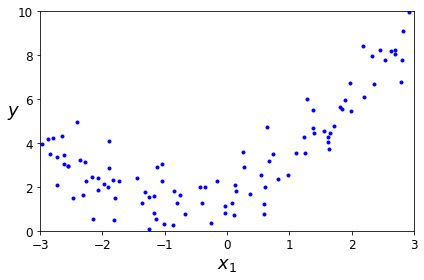

In [28]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

확실히 직선 형태는 위 데이터에 잘 안맞을 것임. 따라서 사이킷런의 **PolynomialFeatures**를 사용해 훈련 데이터를 변환해보겠음(훈련 세트에 있는 각 특성을 제곱(2차 다항)하여 새로운 특성으로 추가) 

In [29]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [30]:
X_poly[0]

array([-0.75275929,  0.56664654])

X_poly는 원래 특성 X와 이 특성 X의 제곱을 포함함. 이 확장된 훈련 데이터에 **Linear Regression**을 적용해보겠음(아래)

In [31]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

계산된 회귀선을 다시 그래프에 그려보면 아래와 같음

그림 저장: quadratic_predictions_plot


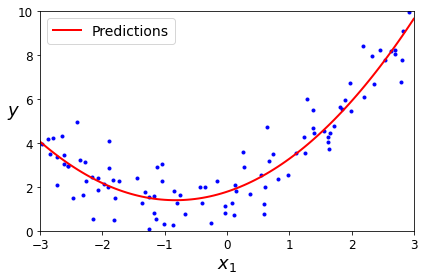

In [32]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

실제 원래 함수: $y = 0.5x_{1}^{2}+1.0x_{1}+2.0+가우시안 잡음$  
예측된 모델: $y = 0.56x_{1}^{2}+0.93x_{1}+1.78$  

나쁘지 않게 예측되었음을 확인 가능

# 4.4 학습 곡선

고차 다항 회귀를 적용하면 보통 선형 회귀에서보다 훨씬 더 훈련 데이터에 잘 맞추려 함.  
아래 그래프는 300차 다항 회귀 모델을 4.3장에서 다룬 훈련 데이터에 적용한 것임. 단순 선형 모델이나 2차 다항 회귀 모델과 결과를 비교해보시길 바람

그림 저장: high_degree_polynomials_plot


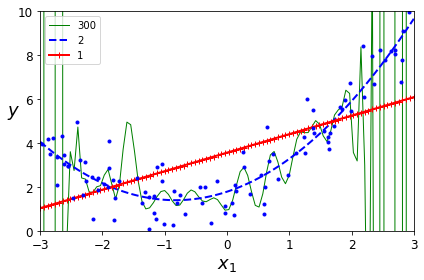

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

위 그래프를 보면 300차 다항 회귀 모델은 훈련 샘플에 가능한 한 가까이 가려고 구불구불하게 나타남  

즉 이 고차 다항 회귀 모델은 훈련 데이터에 심각하게 과대적합되었음. 반면 단순 선형 모델은 과소적합에 해당함. 이 경우 가장 일반화가 잘 될 모델은 2차 다항 회귀 모델임  

위 훈련 데이터는 2차방정식으로 생성한 데이터이기 때문에 당연히 2차 다항 회귀 모델이 가장 적합하지만, 일반적으로는 데이터가 어떤 함수에 제일 적합한지 알 수 없음.  
즉 얼마나 복잡한 모델을 사용할지, 그리고 모델이 데이터에 과대적합 또는 과소적합되었는지 알기 위해서는 새로운 개념이 필요함(2장에서는 모델의 일반화 성능을 추정하기 위해 **교차 검증**을 사용하긴 했음) 

이때 등장하는 개념이 바로 **학습 곡선**  

**학습 곡선 그래프**는 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기(or 훈련 반복)의 함수로 나타낸 그래프임  

아래 코드는 주어진 훈련 데이터에서 모델의 **학습 곡선**을 그리는 함수를 정의함

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              

**단순** 선형 회귀 모델(**직선**)의 학습 곡선을 살펴보겠음(아래)

그림 저장: underfitting_learning_curves_plot


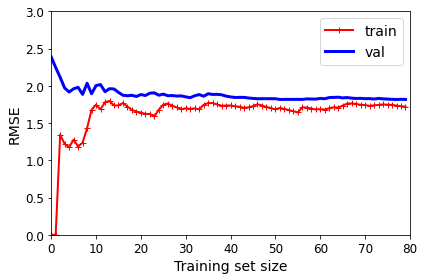

In [35]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         
save_fig("underfitting_learning_curves_plot")   
plt.show()  

<위 그래프 해석>
1. train(훈련 세트) 그래프
- RMSE가 0에서부터 시작 = 훈련 세트에 1개 or 2개의 샘플이 있을 땐 모델이 완벽하게 작동함을 의미
- 하지만 샘플이 추가됨에 따라 잡음도 있고 비선형이기 때문에 모델이 훈련 데이터를 완벽하게 학습하는 것이 불가능해짐. 그래서 곡선이 어느 정도 평편해질 때까지(샘플 수가 약 27개 정도일때까지) 오차(RMSE)가 계속 상승함


2. val(검증 세트) 그래프
- 적은 수의 훈련 샘플로 훈련될 때는 제대로 일반화될 수 없어서 초기에 검증 오차값은 매우 큼
- 모델에 훈련 샘플이 추가됨에 따라 학습이 되고 검증 오차가 천천히 감소함
- 하지만 선형 회귀의 직선은 데이터를 잘 모델링할 수 없으므로 오차의 감소가 완만해져서 훈련 세트의 그래프와 가까워짐

위 학습 곡선 그래프가 **과소적합** 모델의 전형적인 모습임  
: 두 곡선이 수평한 구간을 만들고, 꽤 높은 오차에서 매우 가까이 근접해 있는 형태  

**Tip)** 이렇게 과소적합되어 있을 때는 **훈련 샘플을 더 추가해도 아무 효과가 없음**. 더 복잡한 모델을 사용하거나 더 나은 특성을 선택해야 함

이제 같은 데이터에서 **10차** 다항 회귀 모델의 학습 곡선을 그려보겠음(아래)

그림 저장: learning_curves_plot


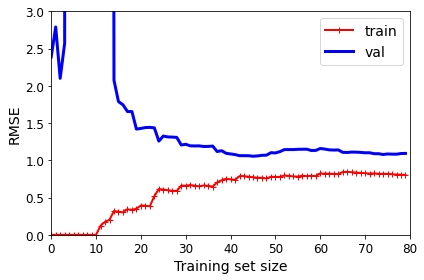

In [36]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])          
save_fig("learning_curves_plot") 
plt.show()

위 학습 곡선은 이전 학습 곡선과 비슷해 보이지만 2가지 매우 중요한 차이점이 있음  
1. 훈련 데이터의 오차(RMSE)가 이전 선형 회귀 모델보다 낮음(약 1.75 -> 약 0.8)
2. 두 곡선 사이에 공간이 있음. 이 말은 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다는 뜻이고, 이는 곧 **과대적합**되었음을 의미함. 그러나 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워지게 됨  

**Tip)** 이렇게 과대적합되어 있을 때는 검증 오차가 훈련 오차에 근접할 때까지 **더 많은 훈련 데이터를 추가하는 것이 모델을 개선**하는 한 가지 방법임

편향과 분산, 그리고 편향/분산 트레이드오프  

편향은 잘못된 가정으로 인해 발생하는 일반화 오차를 말함  
분산은 훈련 데이터에 있는 작은 변동에 모델이 과하게 민감하게 반응하는 정도를 말함  

모델의 복잡도가 커지면 통상적으로 분산은 늘어나고 편향은 줄어듦. 반대로 모델의 복잡도가 줄어들면 편향이 커지고 분산이 작아짐.  
이러한 관계를 "편향/분산 트레이드오프"라고 부름.

# 4.5 규제가 있는 선형 모델

**과대적합**을 감소시키는 좋은 방법: 모델을 **규제**하는 것  

선형 회귀 모델에서는 보통 모델의 **가중치**를 제한함으로써 규제를 가함. 가중치를 제한하는 방법 중 **'릿지' 회귀, '라쏘' 회귀, 엘라스틱넷**을 살펴보겠음

## 4.5.1 릿지 회귀

**릿지(ridge) 회귀(= 티호노프(Tikhonov) 규제)**: 규제가 추가된 선형 회귀 버전  

규제항 $ \alpha \dfrac{1}{2}\sum\limits_{i=1}^{n}{\theta_i}^2 $이 비용 함수에 추가됨. 이는 학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 한 작게 유지되도록 노력함  

규제항은 훈련하는 동안에만 비용 함수에 추가됨. 모델의 훈련이 끝남녀 모델의 성능을 규제가 없는 성능 지표로 평가함

**식 4-8: 릿지 회귀의 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \dfrac{1}{2}\sum\limits_{i=1}^{n}{\theta_i}^2
$

다양한 수준의 릿지 규제를 사용한 선형 회귀(왼쪽)와 다항 회귀(오른쪽) 그래프를 작성하기 위한 코드(아래)

In [38]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

그림 저장: ridge_regression_plot


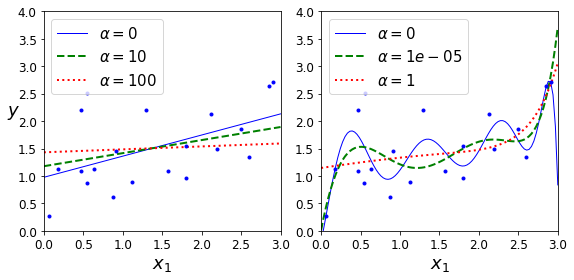

In [39]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

위 그래프를 보면 $\alpha$를 증가시킬수록 직선에 가까워지는 것을 볼 수 있음. 즉, 모델의 분산은 줄지만 편향은 커지게 됨(모델의 복잡도가 줄어들면 편향이 커지고 분산이 작아지는 **편향/분산 트레이드오프**)

사이킷런에서 정규방정식을 사용하여 릿지 회귀를 적용하는 방법은 아래와 같음

In [40]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

아래는 확률적 경사 하강법(SGD)을 사용했을 때 결과임(penalty의 "l2"는 SGD가 비용 함수에 가중치 벡터의 $l_{2}$노름의 제곱을 2로 나눈 규제항을 추가하게 만듦. 즉 릿지 회귀와 같음)

In [41]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

## 4.5.2 라쏘 회귀

**라쏘(Lasso, Least absolute shrinkage and selection operator) 회귀**: 선형 회귀의 또 다른 규제된 버전.  
릿지 회귀처럼 비용 함수에 규제항을 더하는 형태는 같지만, 가중치 벡터의 $l_{2}$노름의 제곱을 2로 나눴던 릿지 회귀와 달리 라쏘 회귀는 **가중치 벡터의 $l_{1}$노름을 사용함**(아래 식 4-10 참고)

**식 4-10: 라쏘 회귀의 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right|
$

앞서 릿지 규제와 같은 데이터에 다양한 수준의 라쏘 규제를 사용한 선형 회귀(왼쪽)와 다항 회귀(오른쪽) 그래프를 작성하기 위한 코드(아래). *그때보다는 조금 더 작은 $\alpha$값을 사용했음*

C:\Users\lkm97\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8028677038274514, tolerance: 0.0009294783355207351
  model = cd_fast.enet_coordinate_descent(


그림 저장: lasso_regression_plot


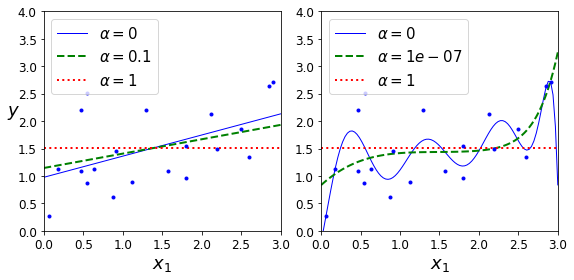

In [42]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

라쏘 회귀의 중요한 특징: 덜 중요한 특성의 가중치를 **제거**하려고 한다는 점  
ex. 오른쪽 그래프에서 $\alpha$=1e-07 그래프는 3차방정식처럼 보임(= 차수가 높은 다항 특성의 가중치가 모두 0이 된 것)  

다시 말해 라쏘 회귀는 자동으로 *특성 선택*을 하고 **희소 모델(sparse model)**을 만듦

라쏘와 릿지 규제의 차이를 모델의 파라미터 2개($\theta_{1}, \theta_{2}$)에 대한 손실 함수(배경의 등고선)으로 살펴보면 아래와 같음(자세한 해석은 교재 p.188,189 참고)

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [48]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

그림 저장: lasso_vs_ridge_plot


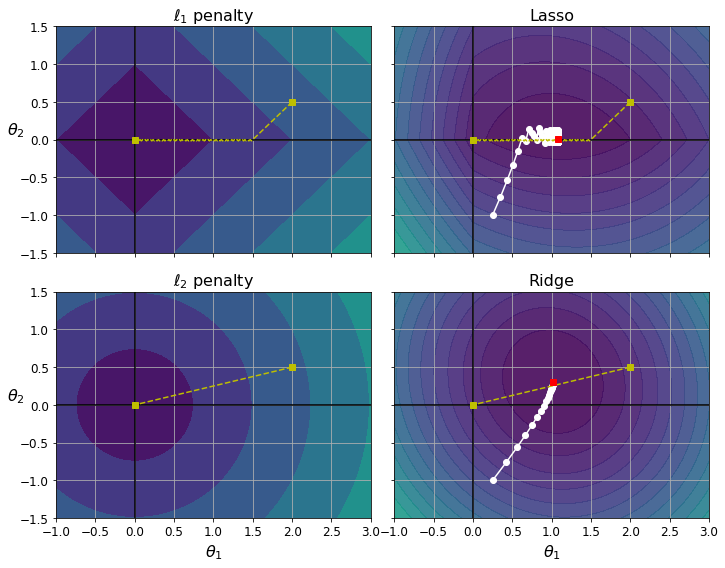

In [49]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

save_fig("lasso_vs_ridge_plot")
plt.show()

사이킷런에서 Lasso 클래스를 사용하여 라쏘 회귀를 적용하는 방법은 아래와 같음

In [44]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

Lasso 대신 SGDRegressor(penalty="l1")을 사용할 수도 있음(아래)

In [45]:
sgd_reg = SGDRegressor(penalty="l1", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47011206])

## 4.5.3 엘라스틱넷

**엘라스틱넷(elastic net)**: 릿지 회귀와 라쏘 회귀를 절충한 모델. 규제항은 **릿지와 라쏘 회귀의 규제항을 단순히 더해서 사용**하며, 혼합 정도는 **혼합 비율 $r$**을 사용해 조절함.  

엘라스틱넷은 $r$=0이면 릿지 회귀와 같고, $r$=1이면 라쏘 회귀와 같음(아래 식 4-12 참고) 

**식 4-12: 엘라스틱넷 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + r \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| + \dfrac{1 - r}{2} \alpha \sum\limits_{i=1}^{n}{{\theta_i}^2}
$

사이킷런에서 ElasticNet을 사용하여 엘라스틱넷을 적용하는 방법은 아래와 같음(**l1_ratio가 혼합비율 $r$임**)

In [46]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

릿지, 라쏘, 엘라스틱넷의 비교  

규제가 있는 선형 모델의 경우 릿지가 기본이 됨  
그러나 실제 쓰이는 특성이 몇 개뿐이라고 의심되면 불필요한 특성의 가중치를 0으로 만들어주는 라쏘나 엘라스틱넷을 주로 사용함  
이때 특성 몇 개가 강하게 연관되어 있을 때 라쏘는 보통 문제를 일으키므로, 라쏘보다는 엘라스틱넷을 주로 사용함

## 4.5.4 조기 종료

**조기 종료(early stopping)**: 검증 에러가 **최솟값**에 도달하면 **바로 훈련을 중지**시키는 방법

아래 코드로 나온 그래프는 배치 경사 하강법으로 훈련시킨 복잡한 모델(고차원 다항 회귀 모델)을 보여줌

In [51]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [52]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서부터 훈련을 이어서 진행
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

그림 저장: early_stopping_plot


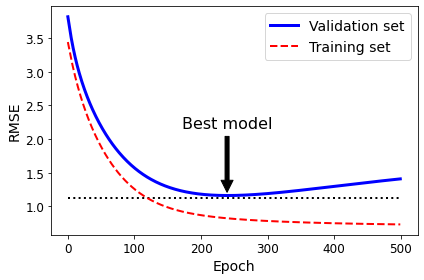

In [53]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

<위 그래프 해석>
* Epoch가 진행됨에 따라 알고리즘이 점차 학습되어 훈련 세트에 대한 예측 에러(RMSE)와 검증 세트에 대한 예측 에러가 줄어듦
* 그러나 잠시 후 감소하던 검증 에러가 멈추었다가 다시 상승함. 이 현상은 모델이 훈련 데이터에 **과대적합**되기 시작하는 것을 의미  

조기 종료는 위처럼 검증 에러가 다시 상승하기 직전, 최소값(**Best model**)에 도달했을 때 즉시 훈련을 멈추는 것임.  

**Tip)** 확률적 경사 하강법(SGD)이나 미니배치 경사 하강법에서는 곡선이 위처럼 매끄럽지 않아 최솟값에 도달했는지 확인하기 어려울 수 있음. 이때 한 가지 해결책은 검증 에러가 일정 시간 동안 최솟값보다 클 때(즉, 모델이 더이상 나아지지 않는다고 확신이 들 때) 학습을 멈추고 검증 에러가 최소였을 때의 모델 파라미터로 되돌리는 것임

조기 종료를 위한 기본적인 구현 코드는 아래와 같음

In [54]:
from sklearn.base import clone

# 데이터 준비
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)), 
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, 
                      penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train) # 훈련을 이어서 진행
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [55]:
best_epoch, best_model

(223,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              tol=-inf, warm_start=True))

에포크(epoch, 반복 횟수)가 223일 때가 제일 좋은 best_epoch라는 것을 알 수 있음

# 4.6 로지스틱 회귀

**로지스틱 회귀(logistic regression)(또는 로짓 회귀, logit regression)**  
: 분류에서도 사용할 수 있는 회귀 알고리즘으로, **샘플이 특정 클래스에 속할 확률을 추정**하는데 널리 사용됨(ex. 이 이메일이 스팸일 확률은 얼마인가?)  

추정 확률이 50%가 넘으면 모델은 그 샘플이 해당 클래스에 속한다고 예측함 = 레이블이 **'1'**인 **양성 클래스(positive class)**  
추정 확률이 50%를 넘지 않으면 모델은 그 샘플이 해당 클래스에 속하지 않는다고 예측함 = 레이블이 **'0'**인 **음성 클래스(negative class)**  
이를 **이진 분류기**라고 함

## 4.6.1 확률 추정

로지스틱 회귀 모델은 선형 회귀 모델과 같이 **입력 특성의 가중치 합을 계산함**. 대신 선형 회귀처럼 바로 결과를 출력하지 않고 결과값의 **로지스틱(logistic)**을 출력  

* **로지스틱**: 0~1 사이의 값을 출력하는 **시그모이드 함수(sigmoid function)**. 자세한 식과 그래프 형태는 아래 참고

**식 4-14: 로지스틱 함수**  
$\sigma(t) = \frac{1}{1 + e^{-t}}$

그림 저장: logistic_function_plot


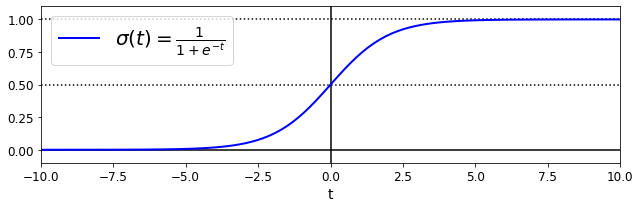

In [56]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

<로지스틱 회귀 모델의 예측 방법>  
t < 0(${\theta}^T \mathbf{x}$ < 0)이면 $\sigma(t)$ < 0.5이므로 0(음성 클래스)이라고 예측  
t >= 0(${\theta}^T \mathbf{x}$ >= 0)이면 $\sigma(t)$ >= 0.5이므로 1(양성 클래스)이라고 예측

## 4.6.2 훈련과 비용 함수

훈련의 목적: 양성 샘플(y=1)에 대해서는 높은 확률을 추정하고 음성 샘플(y=0)에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터 $\theta$를 찾는 것.  
이런 아이디어가 하나의 훈련 샘플 x에 대해 나타낸 비용 함수인 식 4-16에 드러나 있음

**식 4-16: 하나의 훈련 샘플에 대한 비용 함수**

$
c(\boldsymbol{\theta}) =
\begin{cases}
  -\log(\hat{p}) & \text{if } y = 1, \\
  -\log(1 - \hat{p}) & \text{if } y = 0.
\end{cases}
$


<위 식의 해석>  
1. $\hat{p}$이 0에 가까워지는 경우
- -log($\hat{p}$)가 매우 커지므로 타당하다 할 수 있음  
- 모델이 양성 샘플을 0에 가까운 확률로 추정하면 비용이 크게 증가하는 것을 의미  
- 모델이 음성 샘플을 1에 가까운 확률로 추정하면 비용이 크게 증가하는 것을 의미  

2. $\hat{p}$이 1에 가까워지는 경우  
- -log($\hat{p}$)가 0에 가까워지므로 타당하다 할 수 있음  
- 모델이 양성 샘플을 1에 가까운 확률로 추정하면 비용이 0에 가까워지는 것을 의미  
- 모델이 음성 샘플을 1에 가까운 확률로 추정하면 비용이 0에 가까워지는 것을 의미

전체 훈련 세트에 대한 비용 함수는 모든 훈련 샘플의 비용을 평균한 것. 이를 **로그 손실(log loss)**이라 부르며 아래 식 4-17처럼 하나의 식으로 쓸 수 있음

**식 4-17: 로지스틱 회귀 비용 함수(로그 손실)**

$
J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}
$

안타깝게도 위 비용 함수의 최솟값을 계산하는 알려진 해가 없음(정규방정식 같은 것이 없음).  
하지만 이 비용 함수는 볼록 함수이므로 경사 하강법(or 또다른 최적화 알고리즘)이 전역 최솟값을 찾는 것을 보장함  

위 비용 함수 $J(\boldsymbol{\theta})$의 $j$번째 모델 파라미터 $\theta_{j}$에 대해 편미분을 하면 아래 식 4-18과 같음

**식 4-18: 로지스틱 비용 함수의 편도 함수**

$
\dfrac{\partial}{\partial \theta_j} \text{J}(\boldsymbol{\theta}) = \dfrac{1}{m}\sum\limits_{i=1}^{m}\left(\mathbf{\sigma(\boldsymbol{\theta}}^T \mathbf{x}^{(i)}) - y^{(i)}\right)\, x_j^{(i)}
$

## 4.6.3 결정 경계

로지스틱 회귀를 설명하기 위해 붓꽃 데이터셋을 사용하겠음  
꽃잎의 너비를 기반으로 Iris-Versicolor 종을 감지하는 분류기를 만들어보겠음  

먼저 데이터를 로드

In [57]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [58]:
print(iris.DESCR) # iris 데이터셋에 대한 설명

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [59]:
X = iris["data"][:, 3:]  # 꽃잎 너비
y = (iris["target"] == 2).astype(int)  # Iris virginica이면 1 아니면 0

이어서 로지스틱 회귀 모델을 훈련시킴

In [60]:
# 향후 버전이 바뀌더라도 동일한 결과를 만들기 위해 사이킷런 0.22 버전의 기본값인 solver="lbfgs"로 지정

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률을 계산해보겠음

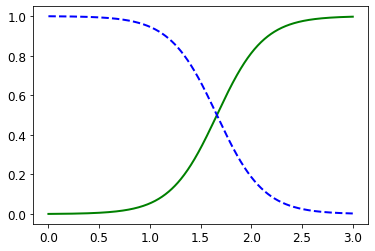

In [61]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

교재와 같이 범례와 축, 기타 설명을 넣으려면 아래처럼 짜면 됨

그림 저장: logistic_regression_plot


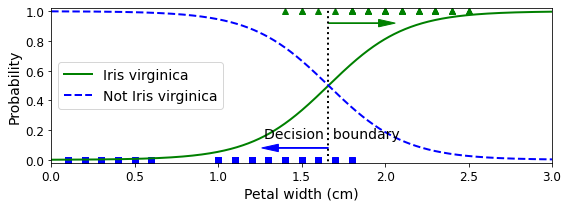

In [62]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary[0], 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary[0], 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

위 그래프를 보면 양쪽의 확률이 똑같이 50%가 되는 1.6cm 근방에서 **결정 경계(Decision boundary)**가 만들어짐(아래 코드 참고)  

In [63]:
decision_boundary

array([1.66066066])

즉 분류기는 꽃잎 너비가 1.6cm보다 크면 Iris-Verginica로 분류하고, 그보다 작으면 아니라고 예측할 것임(아래 코드 참고)

In [64]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

아래 코드로 나오는 그래프는 같은 데이터셋을 이번에는 꽃잎 너비와 꽃잎 길이 2개의 특성으로 보여줌

그림 저장: logistic_regression_contour_plot


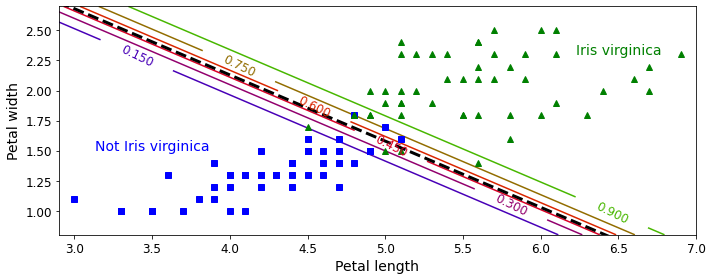

In [65]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

<위 그래프 설명>  
- 검은 색 점선: 모델이 50% 확률을 추정하는 지점, 즉 이 모델의 **결정 경계**  
- 15%(왼쪽 아래)부터 90%(오른쪽 위)까지 나란한 직선들은 모델이 특정 확률을 출력하는 포인트를 나타냄  
- 모델은 맨 오른쪽 위의 직선을 넘어서 있는 꽃들을 90% 이상의 확률로 Iris-Verginica라고 판단할 것임

## 4.6.4 소프트맥스 회귀

**소프트맥스 회귀(softmax regression)**(또는 **다항 로지스틱 회귀, multinomial logistic regression**): 여러 개의 이진 분류기를 훈련시켜 연결하는 방식이 아닌 직접 다중 클래스를 지원하도록 일반화된 로지스틱 회귀 모델  

**식 4-20: 소프트맥스 함수**

$
\hat{p}_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}
$


- $K$: 클래스 수  
- $s(\mathbf{x})$: 샘플 $\mathbf{x}$에 대한 각 클래스의 점수를 담은 벡터  
- $\sigma\left(\mathbf{s}(\mathbf{x})\right)_k$: 샘플 $\mathbf{x}$에 대한 각 클래스의 점수가 주어졌을 때, 이 샘플이 클래스 $k$에 속할 추정 확률

<모델 훈련 방법>  
모델이 타깃 클래스에 대해서는 높은 확률을(다른 클래스에 대해서는 낮은 확률을) 추정하도록 만드는 것이 목적  
아래 식 4-22의 **크로스 엔트로피(cross entropy)** 비용 함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제하므로 이 목적에 부합함  

**크로스 엔트로피**는 추정된 클래스의 확률이 타깃 클래스에 얼마나 잘 맞는지 측정하는 용도로 종종 사용됨

**식 4-22: 크로스 엔트로피 비용 함수**

$
J(\boldsymbol{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
$

- $y_k^{(i)}$: $i$번째 샘플이 클래스 $k$에 속할 타깃 확률. 일반적으로 샘플이 클래스에 속하는지 아닌지에 따라 1 또는 0이 됨  
- 딱 2개의 클래스만 존재할 때($K=2$) 이 비용 함수는 앞서 살펴본 **식 4-17: 로지스틱 회귀의 비용 함수**와 같음

위 비용 함수의 $\theta^{(k)}$에 대한 그레디언트(미분값) 벡터는 아래 식 4-23과 같음

**식 4-23: 클래스 k에 대한 크로스 엔트로피의 그레디언트 벡터**

$
\nabla_{\boldsymbol{\theta}^{(k)}} \, J(\boldsymbol{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
$

이제 각 클래스에 대한 그레디언트 벡터를 계산할 수 있으므로 비용 함수를 최소화하기 위한 파라미터 행렬 $\boldsymbol{\Theta}$를 찾기 위해 경사 하강법(or 다른 최적화 알고리즘)을 사용할 수 있음

**소프트맥스 회귀**를 사용해 붓꽃을 3개의 클래스로 분류해보겠음(아래)  
사이킷런의 **LogisticRegression**은 클래스가 2개 이상일 때 기본적으로 **일대다(OvA) 전략**을 사용함. 하지만 multi_class 매개변수를 **"multinomial"**로 바꾸면 **소프트맥스 회귀**를 사용할 수 있음  

* 소프트맥스 회귀를 사용하려면 **solver** 매개변수에 **"lbfgs"**와 같이 소프트맥스 회귀를 지원하는 알고리즘을 지정해야 함  
* 또한 기본적으로 하이퍼파라미터 **C**를 사용하여 조절할 수 있는 $l_{2}$ 규제가 적용됨

In [66]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

꽃잎의 길이가 5cm, 너비가 2cm인 붓꽃을 발견했다고 가정하고 이 붓꽃의 품종이 무엇인지 모델에게 물어보면 94.2%의 확률로 Iris-Verginica(클래스 2)라고(= 5.8%의 확률로 Iris-Versicolor라고) 출력할 것임(아래)

In [67]:
softmax_reg.predict([[5, 2]]) # 예측 클래스

array([2])

In [68]:
softmax_reg.predict_proba([[5, 2]]) # 예측 클래스일 확률

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

소프트맥스 회귀 결정 경계를 그래프로 시각적으로 나타내는 코드는 아래와 같음

그림 저장: softmax_regression_contour_plot


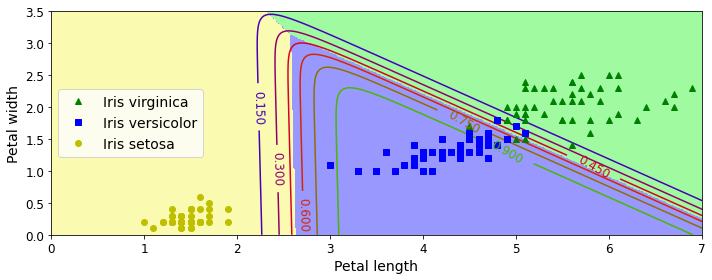

In [69]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

- 위 그래프는 만들어진 결정 경계를 배경색으로 구분하여 나타내고 있음
- 클래스 사이의 결정 경계가 모두 선형임
- 또한 Iris-Versicolor 클래스에 대한 확률을 곡선으로 나타냈음(즉 0.450 직선은 45% 확률 경계를 나타냄)
- 이 모델이 추정 확률 50% 이하인 클래스를 예측할 수도 있다는 점을 주목(ex. 모든 결정 경계가 만나는 지점에서는 모든 클래스가 동일하게 33%의 추정 확률을 가짐)

# END